In [217]:
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from matplotlib import pyplot as plt
from tqdm import tqdm

In [218]:
n_c = 90
hidden_size = 8
file = f'./dataset_reduced_{n_c}.json'

### Datasets


In [219]:
# dataloaders
class IPARC(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            'img_in': torch.tensor(row['input_reduced']).reshape(-1),
            'img_out': torch.tensor(row['output_reduced']).reshape(-1),
            'operation': torch.tensor(row['operation']).reshape(1, -1),
            'kernel': torch.tensor(row['kernel']),
        }

    @staticmethod
    def collate(batch):
        return {
            'img_in': torch.stack([x['img_in'] for x in batch]),
            'img_out': torch.stack([x['img_out'] for x in batch]),
            'operation': torch.stack([x['operation'] for x in batch]),
            'kernel': torch.stack([x['kernel'] for x in batch]),
        }

### Model


In [220]:
class Model(nn.Module):
    def __init__(self, n_c, hdsz):
        super(Model, self).__init__()
        self.op_linreg = nn.Linear(4 * (n_c + n_c) + hdsz, 1)
        self.kernel_linreg = nn.Linear(4 * (n_c + n_c) + hdsz, 8)
        self.hidden_encoder = nn.Linear(hdsz + 1 + 8, hdsz)

    def forward(self, img_in, img_out, op_prev, kernel_prev, hidden):
        hidden = torch.tanh(self.hidden_encoder(torch.cat([hidden, op_prev, kernel_prev], dim=-1)))

        cat = torch.cat([img_in, img_out, hidden], dim=-1)
        op_logit = self.op_linreg(cat)
        kernel_logit = self.kernel_linreg(cat)

        return op_logit, kernel_logit, hidden

### Training Loop


In [221]:
# trainig loop
def train(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    losses = {'train': [], 'test': []}

    for epoch in range(epochs):
        model.train()
        loss_tot = 0
        for batch in train_loader:
            bs = batch['img_in'].shape[0]

            img_in = batch['img_in'].to(device)
            img_out = batch['img_out'].to(device)
            op = batch['operation'].to(device)
            kernel = batch['kernel'].to(device)

            prev_op, prev_kernel = torch.zeros_like(op[:, :, 0], device=device), torch.zeros_like(
                kernel[:, 0], device=device
            )
            hidden = torch.zeros(bs, hidden_size, device=device)

            loss = 0
            n_seq = op.shape[2]
            for i in range(n_seq):
                op_logit, kernel_logit, hidden = model(
                    img_in, img_out, prev_op, prev_kernel, hidden
                )
                op_loss = criterion(op_logit, op[:, :, i].float())
                kernel_loss = criterion(kernel_logit, kernel[:, i].float())
                loss += op_loss + kernel_loss

                prev_op = op[:, :, i]
                prev_kernel = kernel[:, i]

            loss /= n_seq
            loss_tot += loss.detach().cpu().item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses['train'].append(loss_tot / len(train_loader))

        model.eval()
        loss_tot = 0
        with torch.no_grad():
            for batch in test_loader:
                bs = batch['img_in'].shape[0]

                img_in = batch['img_in'].to(device)
                img_out = batch['img_out'].to(device)
                op = batch['operation'].to(device)
                kernel = batch['kernel'].to(device)

                prev_op, prev_kernel = torch.zeros_like(op[:, :, 0],
                                                        device=device), torch.zeros_like(
                                                            kernel[:, 0], device=device
                                                        )
                hidden = torch.zeros(bs, hidden_size, device=device)

                loss = 0
                n_seq = op.shape[2]
                for i in range(n_seq):
                    op_logit, kernel_logit, hidden = model(
                        img_in, img_out, prev_op, prev_kernel, hidden
                    )
                    op_loss = criterion(op_logit, op[:, :, i].float())
                    kernel_loss = criterion(kernel_logit, kernel[:, i].float())
                    loss += op_loss + kernel_loss

                    prev_op = op[:, :, i]
                    prev_kernel = kernel[:, i]

                loss /= n_seq
                loss_tot += loss.detach().cpu().item()
        losses['test'].append(loss_tot / len(test_loader))

        # print(f'Epoch {epoch+1}/{epochs}, Train Loss: {losses["train"][-1]:.4f}, Test Loss: {losses["test"][-1]:.4f}')

    return losses

### K-Fold Cross Validation


In [222]:
df = pd.read_json(file)
df.head(1)
df = df.sample(frac=1)  # shuffle


In [223]:
def k_fold(df, n_c, hidden_size, epochs=10, lr=0.01, k=1, idx=0):
    window = k
    test_df = df[idx * window:(idx + 1) * window]
    train_df = pd.concat([df[:idx * window], df[(idx + 1) * window:]])

    train_loader = DataLoader(IPARC(train_df), batch_size=8, shuffle=True, collate_fn=IPARC.collate)
    test_loader = DataLoader(IPARC(test_df), batch_size=8, shuffle=False, collate_fn=IPARC.collate)

    model = Model(n_c, hidden_size)
    losses = train(model, train_loader, test_loader, epochs, lr)

    return losses

Loss Train: 0.2236, Loss Test: 4.4574:   0%|          | 0/25 [00:24<?, ?it/s]


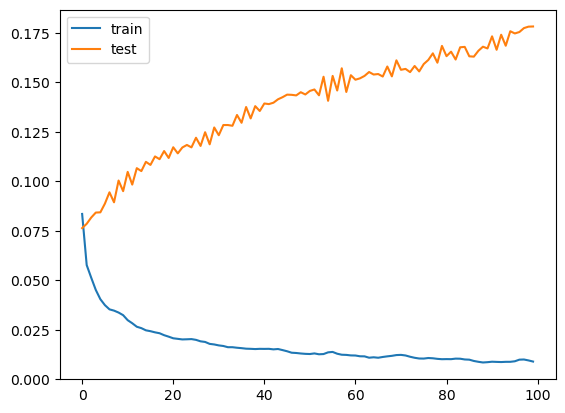

In [224]:
n_epochs = 100
k = 4

loss_dict = {'train': np.zeros(n_epochs), 'test': np.zeros(n_epochs)}

for i in (pbar := tqdm(range(len(df) // k))):
    losses = k_fold(df, n_c, hidden_size, epochs=n_epochs, lr=0.01, k=k, idx=i)
    loss_dict['train'] += np.array(losses['train'])
    loss_dict['test'] += np.array(losses['test'])
    pbar.set_description(
        f'Loss Train: {losses["train"][-1]:.4f}, Loss Test: {losses["test"][-1]:.4f}'
    )

loss_dict['train'] /= len(df) // k
loss_dict['test'] /= len(df) // k

plt.plot(loss_dict['train'], label='train')
plt.plot(loss_dict['test'], label='test')
plt.legend()
plt.show()